In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and Process Data

In [2]:
# === Load Features ===
gin_gout_file = "Data_D1/gin_gout_ratio.csv"
df_features = pd.read_csv(gin_gout_file, header=None)
X = df_features.values  # Features: gout/gin ratios

# === Load Labels ===
test_info_file = "Data_D1/test_info.csv"
df_labels = pd.read_csv(test_info_file, header=None)

# Train Test Split and Transform

Unique Capacity (C) values: [25. 50. 75.]


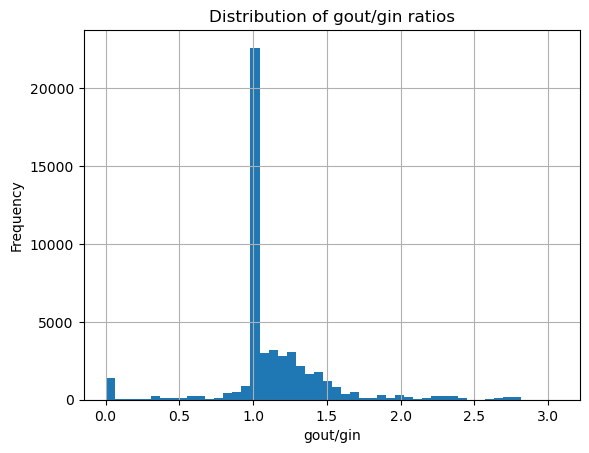

In [3]:
# === Rename columns to match paper notation ===
V_values = df_labels.iloc[:, 0].values  # ✅ V = Capacity (Link Capacity)
C_values = df_labels.iloc[:, 1].values  # ✅ C = Cross Traffic
A_values = V_values - C_values          # ✅ A = Available Bandwidth

# === Debug Print ===
print("Unique Capacity (C) values:", np.unique(C_values))

# === Create Labels Matrix ===
# [A, V] as per the paper (Available Bandwidth, Capacity)
y = np.column_stack((A_values, C_values))  

# === Sanity Check: Match Feature and Label Counts ===
if len(X) != len(y):
    raise ValueError(f"Mismatch: {len(X)} features vs {len(y)} labels.")

# === Normalize A and V using MinMaxScaler ===
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)  # Normalize labels

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y_scaled, test_size=0.2, random_state=42
)

# === Visualize Input Feature Distribution ===
plt.hist(X.flatten(), bins=50)
plt.title("Distribution of gout/gin ratios")
plt.xlabel("gout/gin")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Iterative Model

In [4]:
def build_iterative_bandwidth_estimator(k=20):
    model = keras.Sequential([
        layers.Input(shape=(k+2,)),  
        layers.Dense(64, activation='relu'),  # Increased neurons
        layers.Dense(32, activation='relu'),  # Added hidden layer
        layers.Dense(2, activation='linear')  # Output: A and C
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train the Model

In [5]:
# Train the model
iterative_model = build_iterative_bandwidth_estimator(X_train.shape[1])
iterative_model.fit(np.hstack([X_train, np.zeros((X_train.shape[0], 2))]), y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4296 - mae: 0.5168 - val_loss: 0.1513 - val_mae: 0.3317
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1538 - mae: 0.3340 - val_loss: 0.1426 - val_mae: 0.3209
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1441 - mae: 0.3261 - val_loss: 0.1299 - val_mae: 0.3041
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1368 - mae: 0.3165 - val_loss: 0.1200 - val_mae: 0.2907
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1227 - mae: 0.2981 - val_loss: 0.1145 - val_mae: 0.2838
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1132 - mae: 0.2853 - val_loss: 0.1051 - val_mae: 0.2701
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1094 - mae: 0.2838 - val_loss: 0.0948 - val_mae: 0.2461
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0939 - mae: 0.2547 - val_loss: 0.0876 - val_mae: 0.2414
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0921 - mae: 

# Iterative Prediction

In [6]:
def iterative_prediction(model, X, num_iterations=5, initial_A=50, initial_C=100):
    """
    Iteratively refines predictions for A (Available Bandwidth) and C (Capacity).
    
    Args:
    - model: Trained iterative NN model.
    - X: Input feature matrix (g_out/g_in ratios).
    - num_iterations: Number of refinement steps.
    - initial_A: Initial guess for Available Bandwidth.
    - initial_C: Initial guess for Capacity.
    
    Returns:
    - A, C estimates after iterations.
    """
    A_pred = np.full((X.shape[0], 1), initial_A)
    C_pred = np.full((X.shape[0], 1), initial_C)
    
    for _ in range(num_iterations):
        input_data = np.hstack([X, A_pred, C_pred])  # Combine features with previous estimates
        predictions = model.predict(input_data)
        A_pred, C_pred = predictions[:, 0].reshape(-1, 1), predictions[:, 1].reshape(-1, 1)
    
    return A_pred, C_pred

# Print the Results

In [7]:
# Evaluate model
A_pred, C_pred = iterative_prediction(iterative_model, X_test)
mse_A = np.mean((A_pred - y_test[:, 0])**2)
mse_C = np.mean((C_pred - y_test[:, 1])**2)

print(f'MSE for A: {mse_A:.4f}, MSE for C: {mse_C:.4f}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
MSE for A: 0.4015, MSE for C: 0.4805


# Simple NN Model

In [8]:
# Define the model (same as your `build_bandwidth_estimator`)
def build_bandwidth_estimator(k=25):
    model = keras.Sequential([
        layers.Input(shape=(k,)),  # Input layer (expects 20 features)
        layers.Dense(40, activation='relu'),  # Hidden layer with 40 neurons
        layers.Dense(2, activation='linear')  # Output layer (predicts A and C)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Ensure input dimension matches model expectation
k = X_train.shape[1]
model = build_bandwidth_estimator(k)
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 40)                  │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              82 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 962 (3.76 KB)

 Trainable params: 962 (3.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2909 - mae: 0.4285 - val_loss: 0.1556 - val_mae: 0.3346
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1632 - mae: 0.3432 - val_loss: 0.1408 - val_mae: 0.3159
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1450 - mae: 0.3236 - val_loss: 0.1332 - val_mae: 0.3075
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1394 - mae: 0.3192 - val_loss: 0.1253 - val_mae: 0.2978
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1338 - mae: 0.3088 - val_loss: 0.1274 - val_mae: 0.3038
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1218 - mae: 0.2943 - val_loss: 0.1139 - val_mae: 0.2831
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1160 - mae: 0.2897 - val_loss: 0.1088 - val_mae: 0.2768
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1154 - mae: 0.2864 - val_loss: 0.1031 - val_mae: 0.2688
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1084 - mae: 

In [9]:
# Evaluate model on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict Available Bandwidth (A) and Capacity (C)
predictions = model.predict(X_test)
print("Predicted A and C values:\n", predictions)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 0.0274 - mae: 0.1324
Test Loss: 0.0317717008292675, Test MAE: 0.13576942682266235
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
Predicted A and C values:
 [[ 1.67056352e-01  8.17963958e-01]
 [ 5.10967672e-02  9.43879485e-01]
 [ 6.87996089e-01  3.30785364e-01]
 [-1.18530989e-02  1.02087665e+00]
 [ 6.17971122e-02  9.35561895e-01]
 [ 8.63465250e-01  1.47573799e-01]
 [ 7.18335271e-01  2.94556350e-01]
 [ 8.65007341e-02  9.40370679e-01]
 [ 5.66777587e-01  4.22160357e-01]
 [ 4.96489048e-01  4.90420669e-01]
 [ 2.85302788e-01  7.78153539e-01]
 [ 7.84016967e-01  1.50583625e-01]
 [ 7.19915688e-01  3.59205067e-01]
 [ 3.51863503e-01  6.15306497e-01]
 [-1.75084442e-01  1.25239420e+00]
 [ 1.10059589e-01  8.47153544e-01]
 [ 7.46293902e-01  1.42201096e-01]
 [ 1.14757419e-01  9.14808869e-01]
 [ 5.58910131e-01  4.38342541e-01]
 [ 5.53954720e-01  4.02471393e-01]
 [ 6.10316038e-01  3.98783475e-01]
 [ 8.09423029e-02  9.40770268e-01]
 [ 6.89839900e-01  3.26109827e-

In [10]:
# === Inverse transform scaled predictions and true labels ===
y_test_actual = scaler.inverse_transform(y_test)
simple_preds_actual = scaler.inverse_transform(predictions)
iter_preds_actual = scaler.inverse_transform(np.hstack([A_pred, C_pred]))

# === Extract values ===
A_true = y_test_actual[:, 0]            # Available Bandwidth
C_true = y_test_actual[:, 1]            # Cross Traffic (C)

A_simple = simple_preds_actual[:, 0]
C_simple = simple_preds_actual[:, 1]

A_iterative = iter_preds_actual[:, 0]
C_iterative = iter_preds_actual[:, 1]

# === Comparison DataFrame ===
df_C_comparison = pd.DataFrame({
    "True C (Cross Traffic)": C_true,
    "Predicted C (Simple NN)": C_simple,
    "Predicted C (Iterative NN)": C_iterative
})

# === Show Comparison ===
print(df_C_comparison.head(20))
print("\nUnique Cross Traffic values in this batch:", np.unique(C_true))

    True C (Cross Traffic)  Predicted C (Simple NN)  \
0                     75.0                65.898201   
1                     75.0                72.193977   
2                     50.0                41.539268   
3                     75.0                76.043831   
4                     75.0                71.778091   
5                     25.0                32.378693   
6                     50.0                39.727818   
7                     75.0                72.018532   
8                     50.0                46.108021   
9                     50.0                49.521034   
10                    75.0                63.907677   
11                    25.0                32.529182   
12                    50.0                42.960255   
13                    50.0                55.765324   
14                    75.0                87.619713   
15                    75.0                67.357674   
16                    25.0                32.110054   
17        

In [11]:
def plot_grouped_C_predictions(true_C, pred_C_dict, bin_width=12.5):
    bins = np.arange(0, np.ceil(true_C.max()) + bin_width, bin_width)
    bin_centers = bins[:-1] + bin_width / 2

    plt.figure(figsize=(8, 5))

    for label, pred_C in pred_C_dict.items():
        means, stds = [], []
        for i in range(len(bins) - 1):
            # Include right edge for the last bin to avoid excluding max value
            if i == len(bins) - 2:
                mask = (true_C >= bins[i]) & (true_C <= bins[i + 1])
            else:
                mask = (true_C >= bins[i]) & (true_C < bins[i + 1])

            if np.any(mask):
                means.append(np.mean(pred_C[mask]))
                stds.append(np.std(pred_C[mask]))
            else:
                means.append(np.nan)
                stds.append(np.nan)

        plt.errorbar(bin_centers, means, yerr=stds, fmt='o-', capsize=5, label=label)

    # Add ideal y = x line
    max_val = max(np.ceil(true_C.max()), np.ceil(max([np.nanmax(p) for p in pred_C_dict.values()])))
    plt.plot([0, max_val], [0, max_val], 'k--', label='Ideal (y = x)')

    plt.xlabel("True Cross Traffic (C) [Mbps]")
    plt.ylabel("Predicted Cross Traffic [Mbps]")
    plt.title("Grouped Cross Traffic Predictions with Error Bars")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xlim(0, max_val)
    plt.ylim(-5, max_val)
    plt.show()


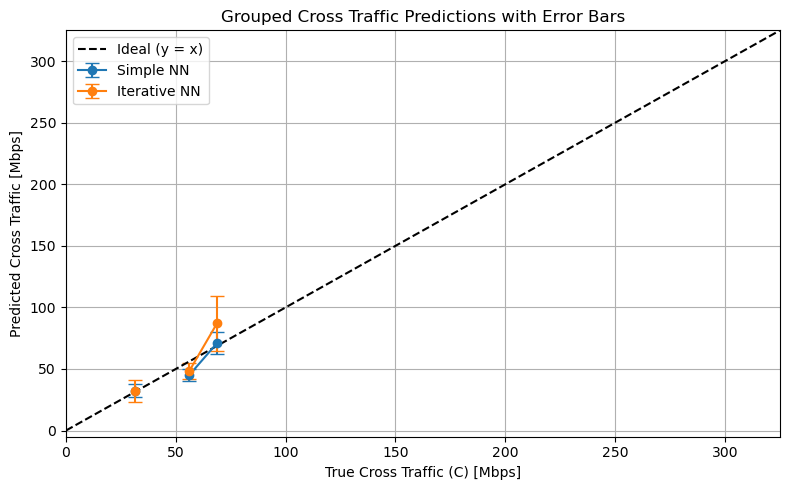

In [12]:
plot_grouped_C_predictions(
    C_true,
    {
        "Simple NN": C_simple,
        "Iterative NN": C_iterative
    },
    bin_width=12.5
)
